# Успешность игры

**Описание:** данные о платформах и их играх с 1980 по 2016 год (данные за 2016 год неполные), о жанрах игр, о количестве продаж, разделенных по регионах, оценка критиков и пользователей, рейтинг от организации ESRB. 

**Цель** - выявить определяющие успешность игры закономерности. 

**План работы:** 
1. Изучить общую информацию датафрейма.
2. Сделать предобработку данных.
3. Сделать исследовательский анализ данных. 
4. Сделать визуализацию.
5. Сделать статистический анализ данных: сформулировать гипотезы - проверить их.
6. Написать общий вывод и рекомендации для бизнеса.

## Импорт и изучение данных:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

Изучу общую информацию о датасете:

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Предобработка данных
Исправим стиль в заголовках столбцов, исключим пропуски. Затем проверим данные на дубликаты.

### Стиль заголовков

In [6]:
# Приведу к общепринятому стилю названия столбцов:
data.columns = data.columns.str.lower()

### Пропуски значений

In [7]:
# Изучу датафрейм на наличие пропусков:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Удалю те столбцы, которые не нуждаются в доп. обработке, и в которых пропусков меньше 5% от отбщего объема дф. Потому что потеря такого объёма данных не критичная, а качественно эти данные не заменить.

In [8]:
data.dropna(subset = ['name', 'year_of_release', 'genre'], inplace = True)

После удаления пропусков можно поменять тип данных в годах выпуска игр.

In [9]:
data['year_of_release'] = data['year_of_release'].astype('int')

"Заглушу" пропуски в рейтинге, чтобы можно было дальше качественно с ними работать, а терять данные во всем датафрейме из-за этих пропусков не хотелось бы.

In [10]:
data['rating'] = data['rating'].fillna('unknown')

### Дубликаты:

Работа с неявными дубликатами:

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Теперь поработаю со значениями 'tbd'. Сам термин означает, что оценка еще не определена, но будет определена, в нашем случае это можно приравнять к пропускам, качественной ценности не имеет.

In [12]:
def replace_wrong_user_scores(wrong_user_scores, correct_user_score):
  data['user_score'] = data['user_score'].replace(wrong_user_scores, correct_user_score)
replace_wrong_user_scores('tbd', np.NaN)

После всех изменений в столбце "оценка пользователей" можно и поменять тип.

In [13]:
data['user_score'] = data['user_score'].astype(float)

<b> Причины пропусков: </b> это может быть как потеря данных во время изменения типа файла, конвертации, передачи и тд, также может быть человеческий фактор - забыли указать. Так же возможно, что не был известен точно год релиза, либо не была проставлена оценка.

Посчитаю суммарные продажи во всех регионах и запишу их в отдельный столбец:

In [14]:
data['sum_sales_game'] =  data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data_all = data 

In [15]:
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  sum_sales_game   16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name :

## Исследовательский анализ данных

<b> Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?</b>

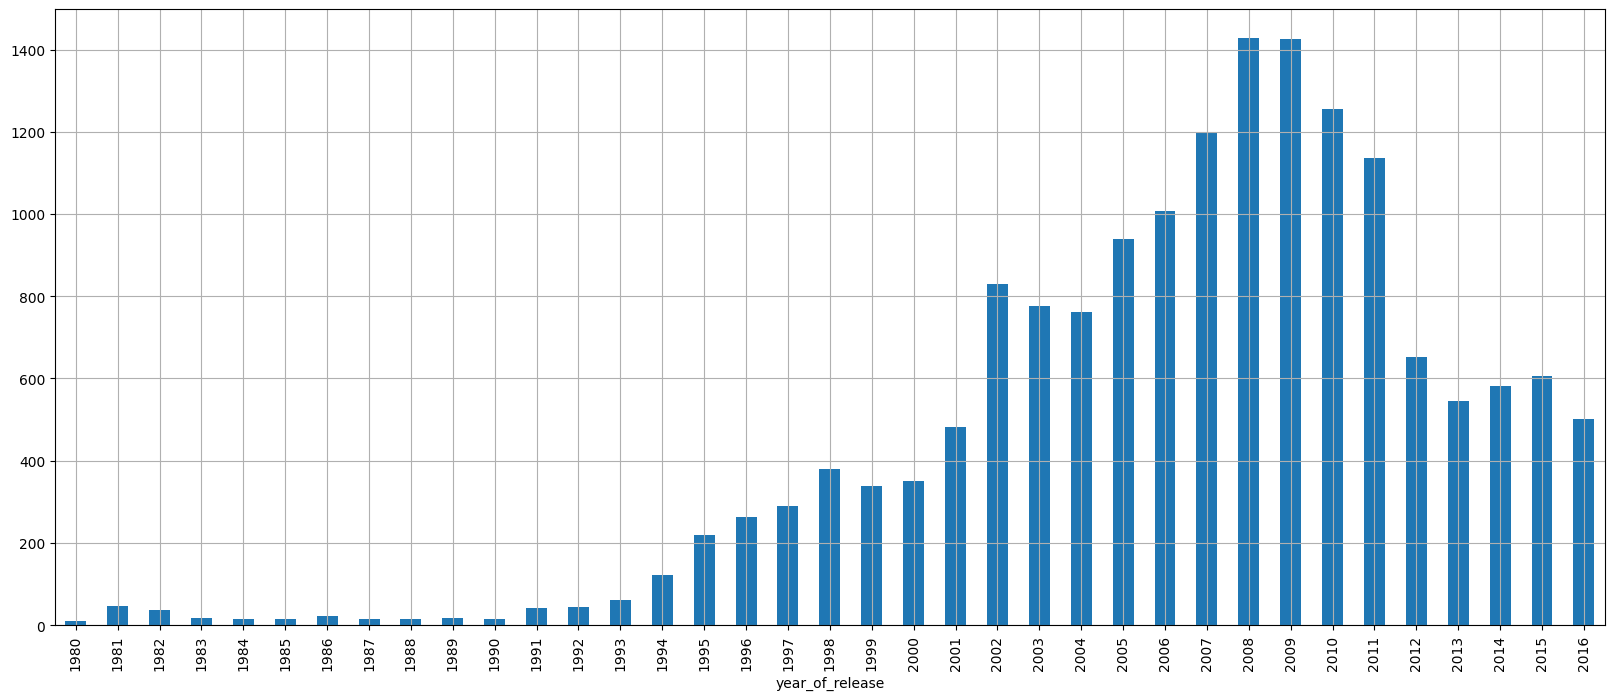

In [16]:
x = data.groupby(['year_of_release'])['name'].count()
x.plot(x = 'year_of_release', y = 'name', kind = 'bar', figsize=(20,8), grid=True)
plt.show()

Здесь я просто узнала количество выпущенных игр за каждый год.

Все года для анализа не важны, так как исторческие данные уже неактульны, и только помешают анализу и прогнозированию. Поэтому нам нужно определить актуальные периоды

<b> Посмотрим, как менялись продажи по платформам. Выберу платформы с наибольшими суммарными продажами и построю распределение по годам. Узнаем, за какой характерный срок появляются новые и исчезают старые платформы?</b>

Построим сводную таблицу по платформам с наибольшими суммарными продажами:

In [17]:
tabl = data.pivot_table(index='platform', values='sum_sales_game', aggfunc='sum').sort_values('sum_sales_game',ascending=False).head()
display(tabl)


,sum_sales_game
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78


Мы нашли 5 самых успешных по продажам платформ за все года, построим по ним графики:

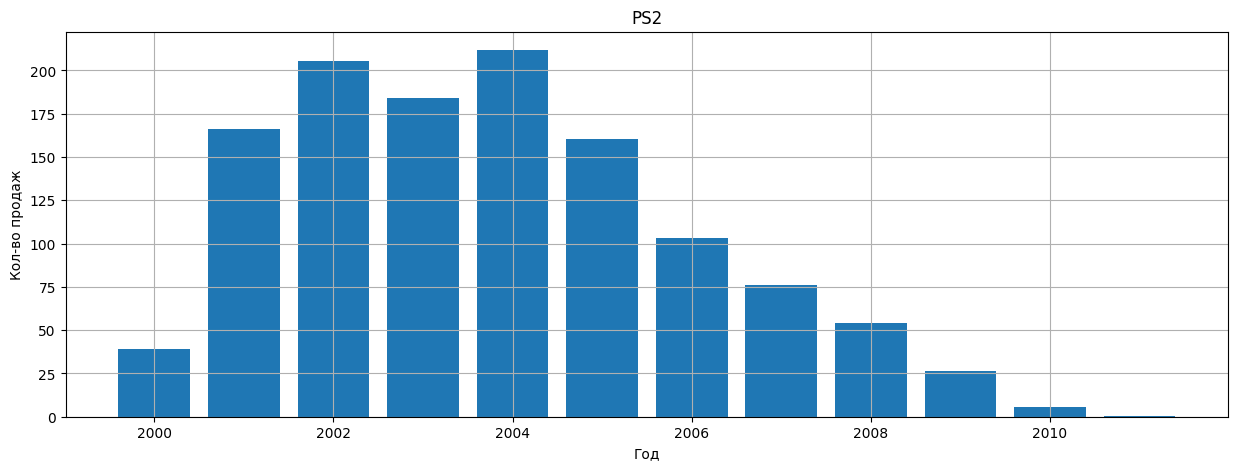

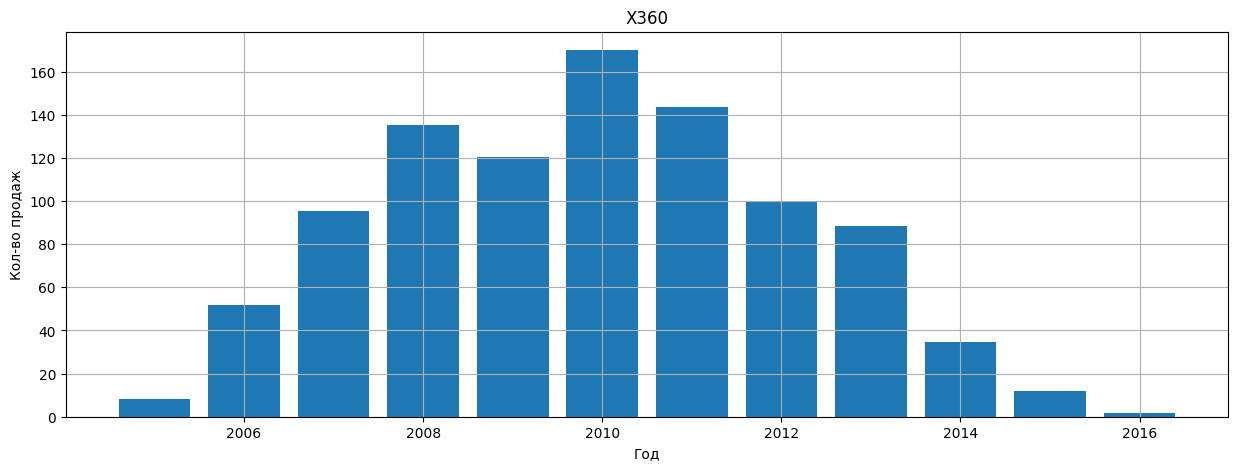

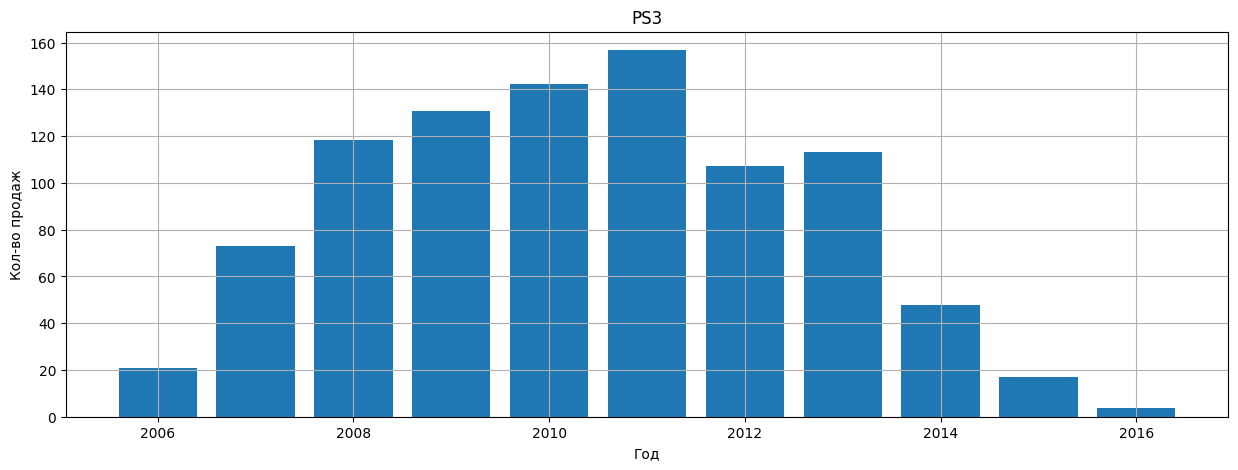

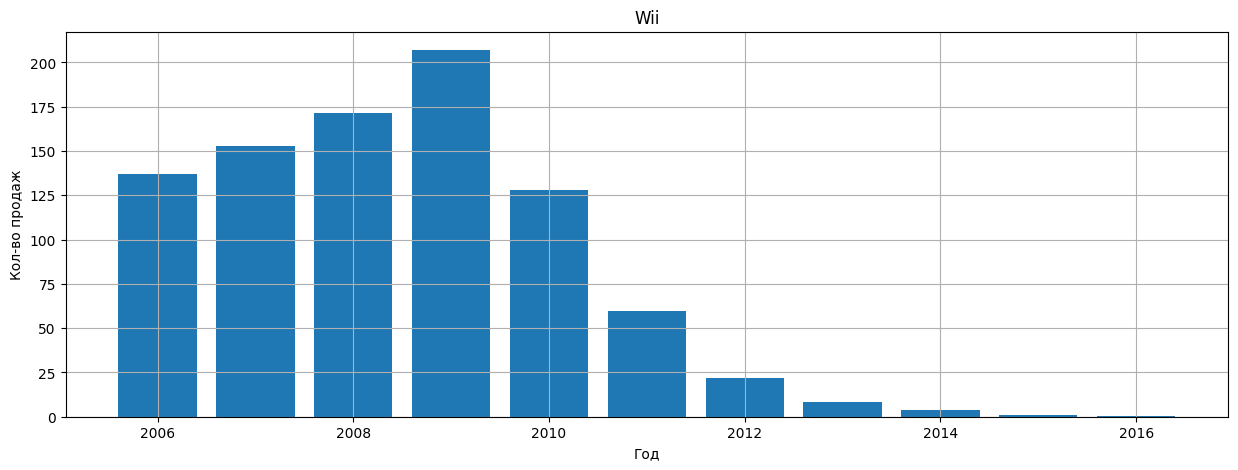

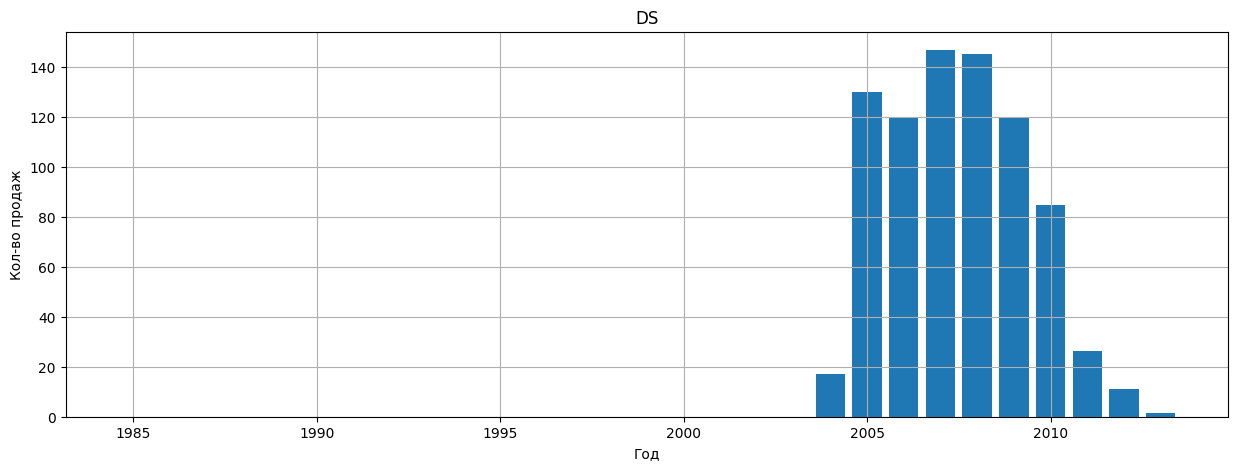

In [18]:
for i in tabl.index:
    plt.figure(figsize=(15, 5))
    x = data.loc[data['platform'] == i].pivot_table(index='year_of_release', values='sum_sales_game', aggfunc='sum')
    plt.bar(x.index, x['sum_sales_game'])
    plt.title(i)
    plt.xlabel('Год')
    plt.ylabel('Кол-во продаж')
    plt.grid()
    plt.show()

Мы вывели 5 самых успешных по числу продаж платформ и построили по ним столбчатые диаграммы. Как можно увидеть, у каждой платформы были разные пики и разные падения, что хорошо отражает столбчатая диаграмма. В среднем каждая платформа живёт где-то 11 лет.

<b> Возьмем данные за соответствующий актуальный период:

Было решено, что актуальным периодом является 2014-2016 года.

In [19]:
data = data.loc[data['year_of_release']>=2014]

<b> Узнаем, какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.</b>

Построим графики по продажам на каждой платформе по каждому из актуальных годов 

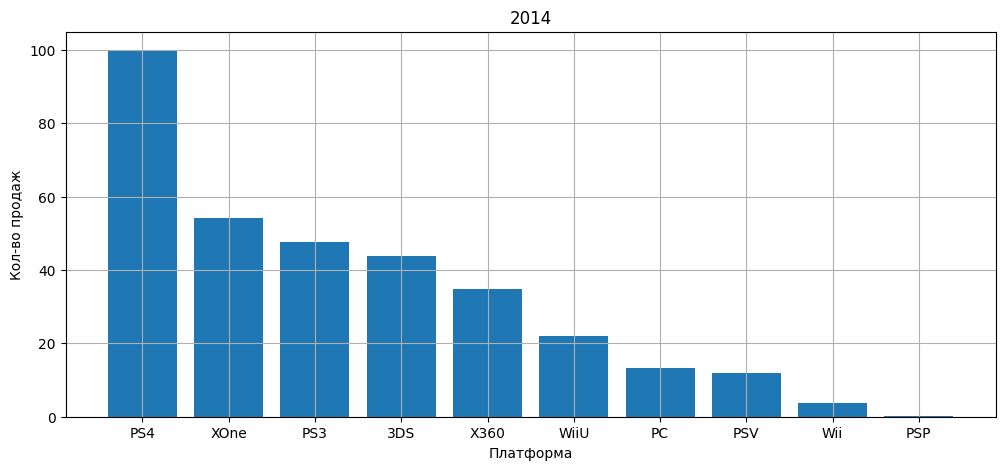

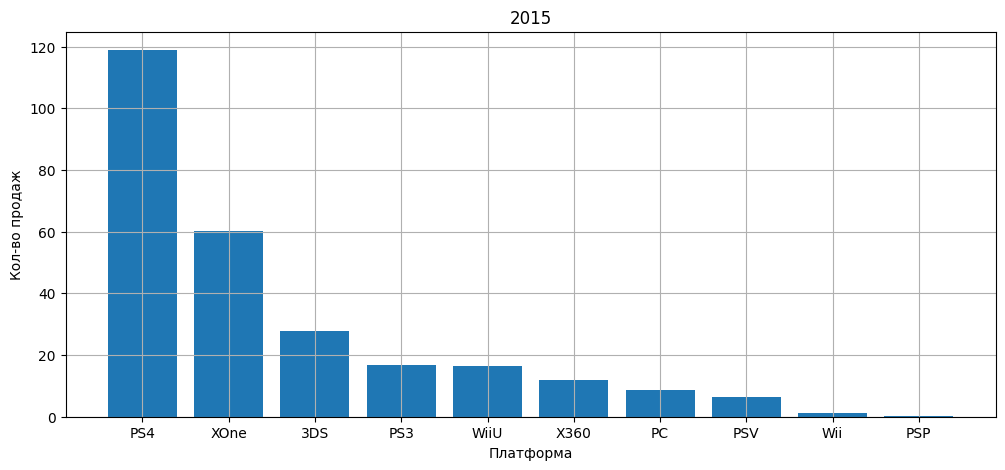

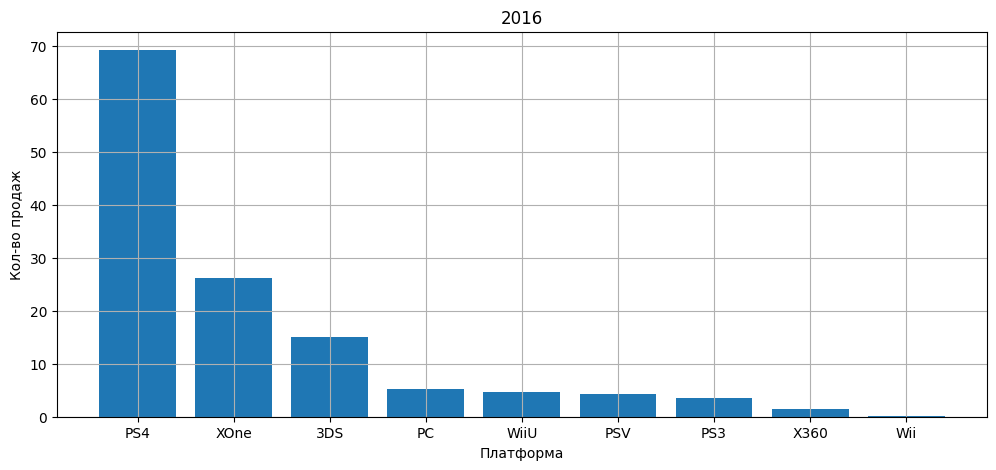

In [20]:
for i in range (2014, 2017):
    act = data.loc[data['year_of_release'] == i].pivot_table(index='platform',values='sum_sales_game', aggfunc='sum').sort_values('sum_sales_game', ascending=False)
    plt.figure(figsize=(12, 5))
    plt.bar(act.index, act['sum_sales_game'])
    plt.title(i)
    plt.xlabel('Платформа')
    plt.ylabel('Кол-во продаж')
    plt.grid()
    plt.show()

Мы стали оценивать платформы по данным последних лет с 2014 до 2016, так как графики по платформам показали нам, что самые успешные платформы имеют свой активный срок жизни примерно 11 лет, то взяв период за последние 3 года, мы точно сможем отследить динамику последних трендов. Мы построили графики по каждому году, и они нам показали, что в 2014 году уже была ПС4 на 1 месте по продажам, за ней на втором месте идёт XOne, но с 2014 года ее отставание в продажах только увеличивается. Так же с 2015 года на 2016 сильно просела по продажам и ПС4 (на 50 пунктов, это результат хуже 2014 года), но пока мы не видим явных конкуренов для этой платформы

Так же на 2016 год всё еще перспективными остаются:

PS4. Даже если будет снижающийся тренд и дальше, то всё равно кол-во продаж очень велико, поэтому сомневаться в перспективности этой консольки не будем

Xone. Если в след году продажи просядут в 1,5-2 раза, то продажи всё равно будут достигать 15-20 млн, что достаточно высокий показатель. А с 2014 к 2015 году был заметен даже небольшой рост продаж этой платформы

Платформа 3DS вызывает подозрения. За последние три года была просадка от 40 до 15, что говорит о стремительном падении. Поэтому заработать на ней еще можно, но очень осторожно

PC. Последние годы продажи хоть и имеют снижающийся тренд, но тренд очень медленный. Относительные продажи данной платформы невелики, но в след году можно рассчитывать примерно на 3-5 млн продаж по нашему тренду.

<b> Постром график «ящик с усами» по глобальным продажам игр в разбивке по платформам.</b>

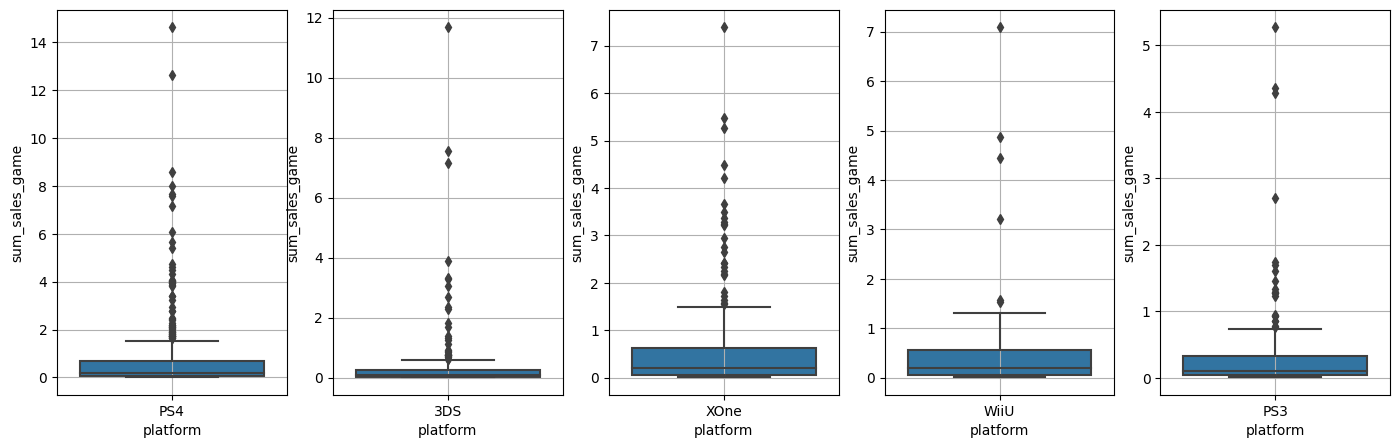

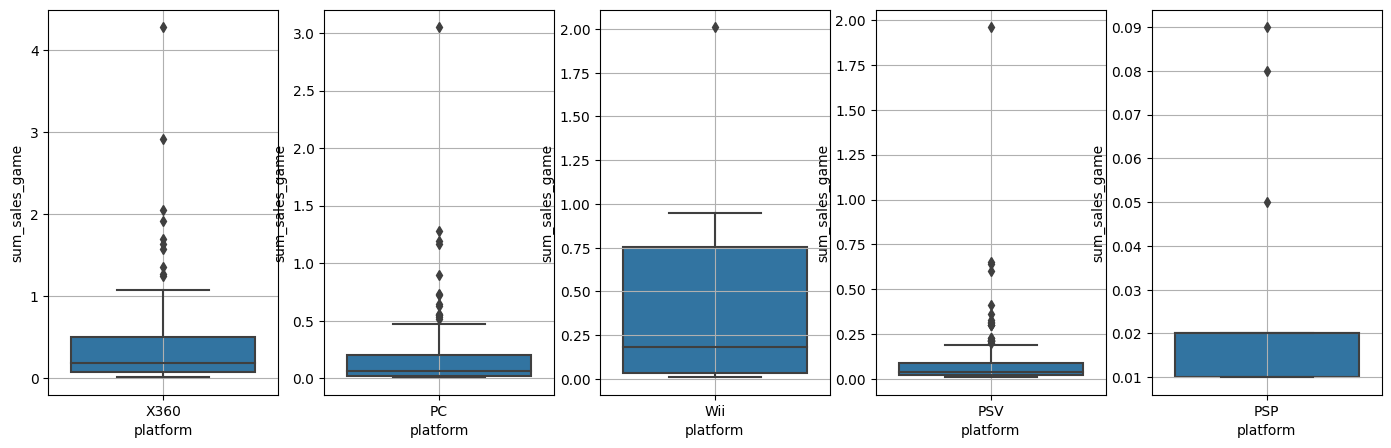

In [62]:
# построим ящик с усами
plt.figure(figsize=(35, 5))
n=0
for i in data['platform'].unique():
    P = data.loc[data['platform'] == i]
    plt.subplot(1,len(data['platform'].unique()),1+n)
    sns.boxplot(data = P, x = 'platform' , y = 'sum_sales_game')
    plt.grid()
    n+=1
    if n == 5:
        plt.show()
        plt.figure(figsize=(35, 5))
plt.show()


Мы построили боксплот по каждой платформе от общего числа продаж. В данном месте для анализа данных я не считаю этот график здесь уместным, так как у нас распределение идёт только в одну сторону от нуля, а следовательно, один "ус" будет очень тяжелым, а следовательно нельзя будет грамотно оценить выбросы. Например, платформа PS имеет слабый ящик и неразличимые на графики квертили, но при этом есть очень удалённое значение. Это можно трактовать как выброс (как говорит график), а может быть и одной успешно выпущенной игрой на данной платформе, которая тянет продажи и приносит основную прибыль.

Так как боксплот оказался очень малым из-за масштабов выбросов, то было принято решение о построении еще одной группы графиков этого типа. Однако здесь для более детального рассмотрения были поставлены ограничения по оси У равные тройной медиане каждого графика.

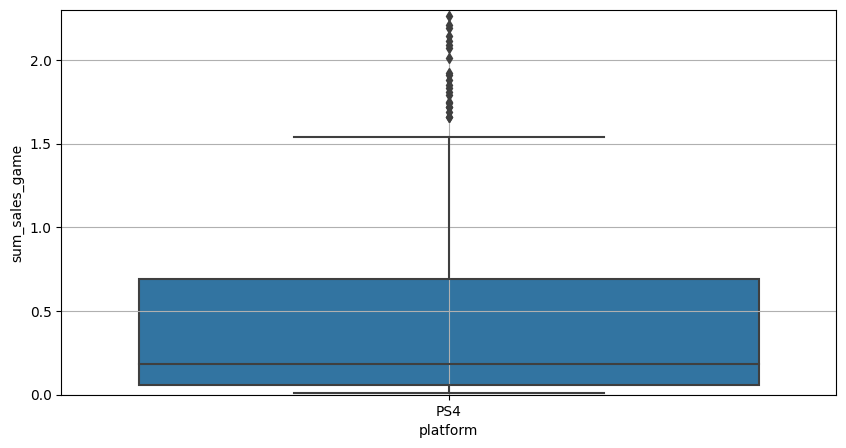

count    376.000000
mean       0.766356
std        1.614969
min        0.010000
25%        0.057500
50%        0.185000
75%        0.690000
max       14.630000
Name: sum_sales_game, dtype: float64


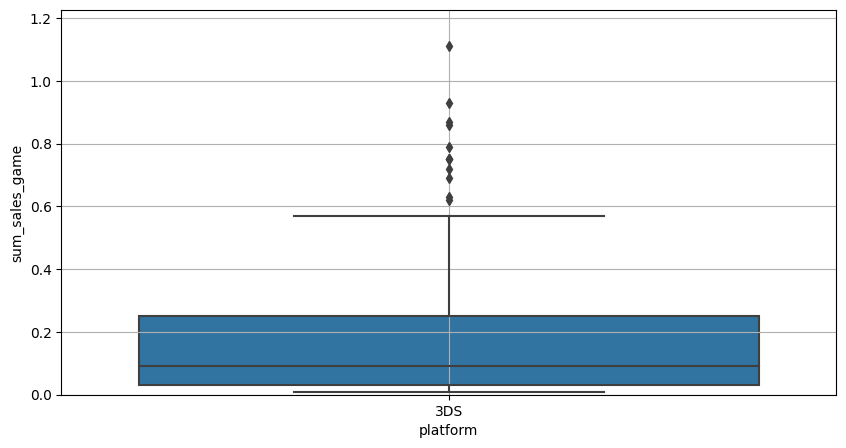

count    212.000000
mean       0.408868
std        1.188368
min        0.010000
25%        0.030000
50%        0.090000
75%        0.250000
max       11.680000
Name: sum_sales_game, dtype: float64


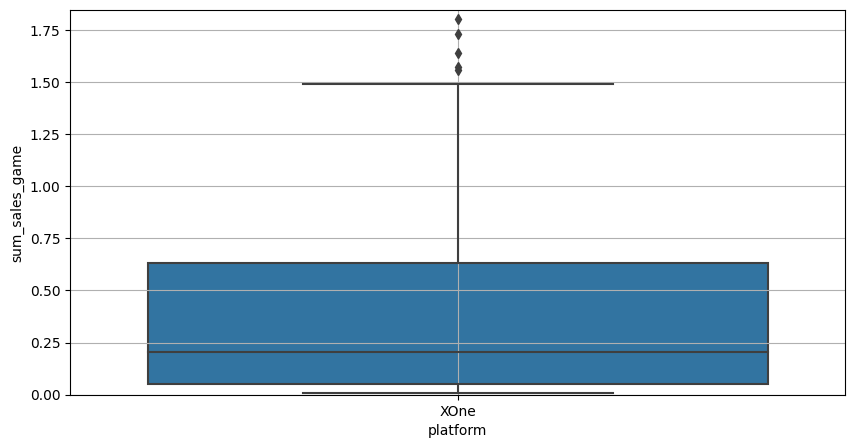

count    228.000000
mean       0.615614
std        1.046513
min        0.010000
25%        0.050000
50%        0.205000
75%        0.632500
max        7.390000
Name: sum_sales_game, dtype: float64


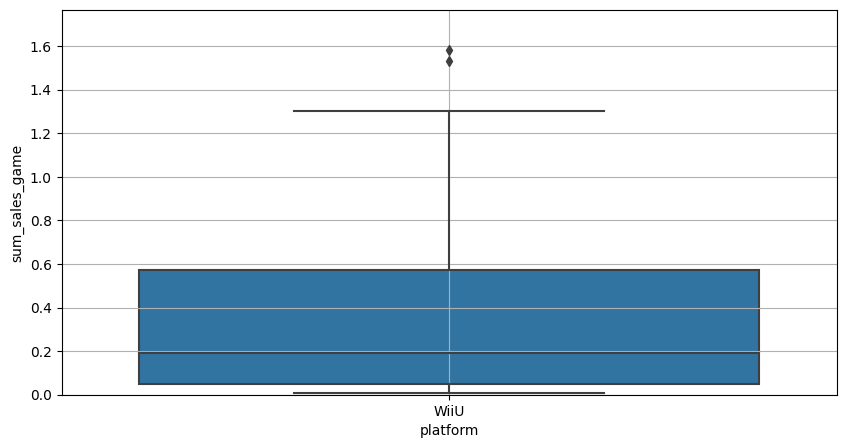

count    73.000000
mean      0.588767
std       1.161467
min       0.010000
25%       0.050000
50%       0.190000
75%       0.570000
max       7.090000
Name: sum_sales_game, dtype: float64


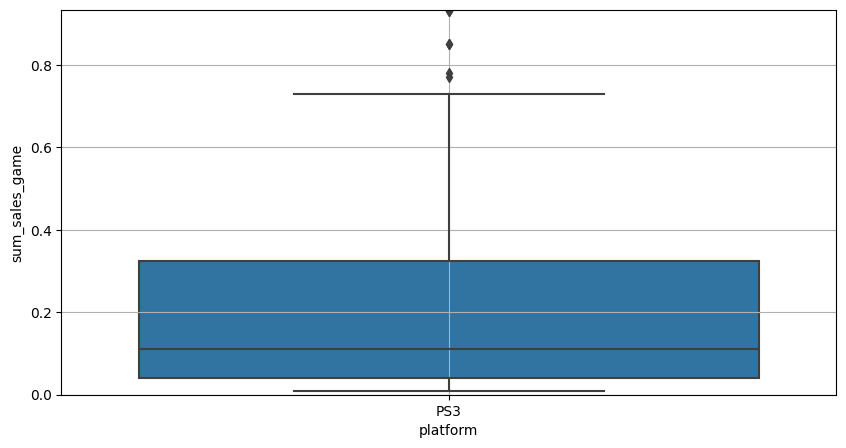

count    219.000000
mean       0.311324
std        0.633059
min        0.010000
25%        0.040000
50%        0.110000
75%        0.325000
max        5.270000
Name: sum_sales_game, dtype: float64


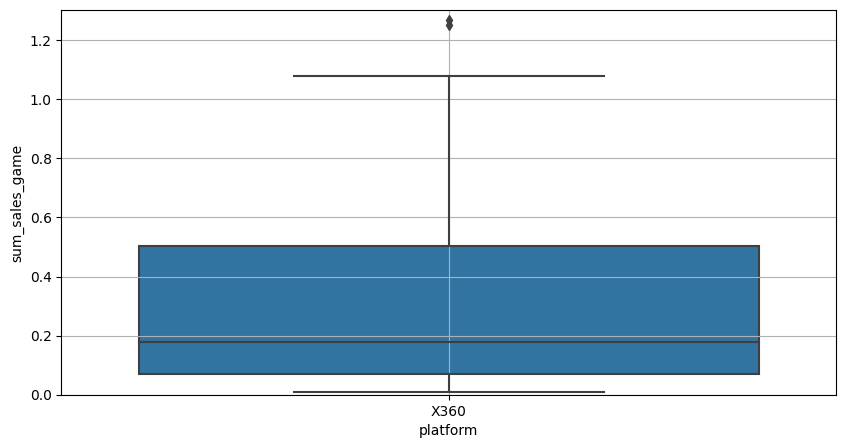

count    111.000000
mean       0.434414
std        0.628967
min        0.010000
25%        0.070000
50%        0.180000
75%        0.505000
max        4.280000
Name: sum_sales_game, dtype: float64


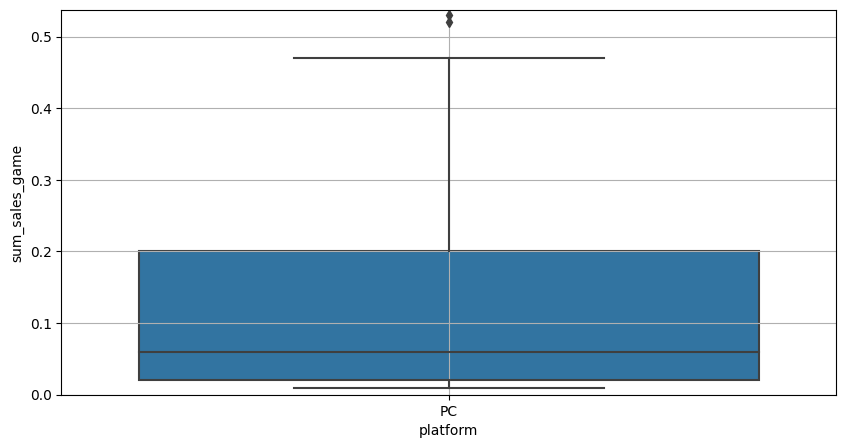

count    151.000000
mean       0.179139
std        0.329359
min        0.010000
25%        0.020000
50%        0.060000
75%        0.200000
max        3.050000
Name: sum_sales_game, dtype: float64


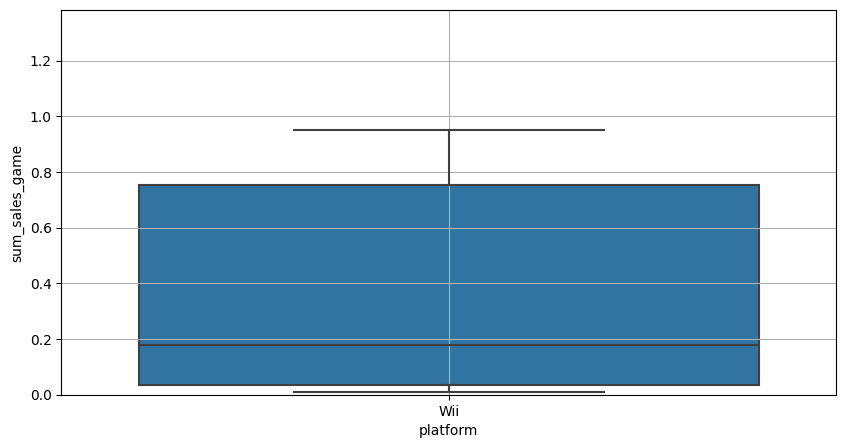

count    11.000000
mean      0.460909
std       0.625451
min       0.010000
25%       0.035000
50%       0.180000
75%       0.755000
max       2.010000
Name: sum_sales_game, dtype: float64


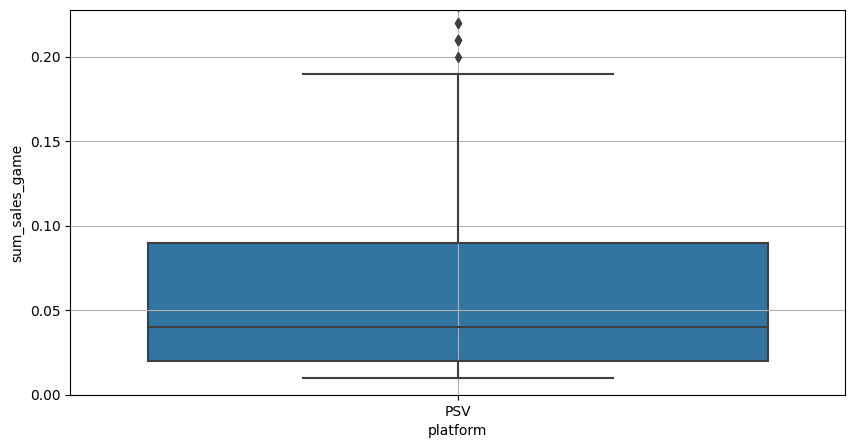

count    295.000000
mean       0.075932
std        0.141591
min        0.010000
25%        0.020000
50%        0.040000
75%        0.090000
max        1.960000
Name: sum_sales_game, dtype: float64


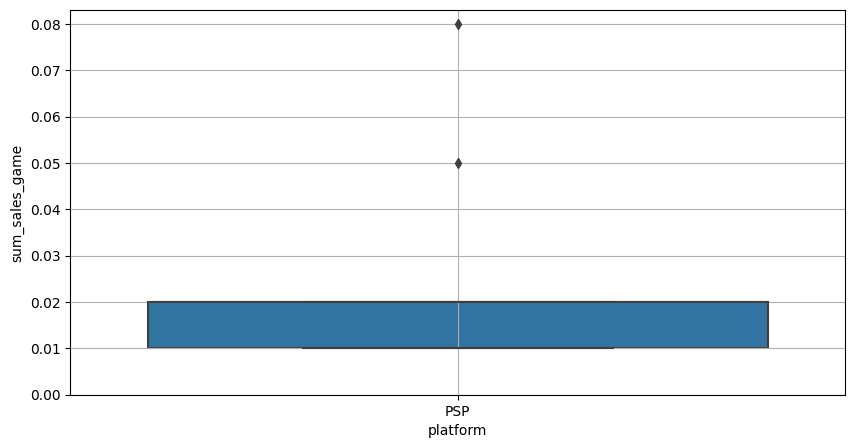

count    13.000000
mean      0.027692
std       0.027735
min       0.010000
25%       0.010000
50%       0.020000
75%       0.020000
max       0.090000
Name: sum_sales_game, dtype: float64


In [22]:
for i in data['platform'].unique():
    P = data.loc[data['platform'] == i]
    plt.figure(figsize=(10, 5))
    plt.ylim(0, data[data['platform'] == i]['sum_sales_game'].mean() * 3)
    sns.boxplot(data = P, x = 'platform' , y = 'sum_sales_game')
    plt.grid()
    plt.show()
    print(data.loc[data['platform'] == i]['sum_sales_game'].describe())

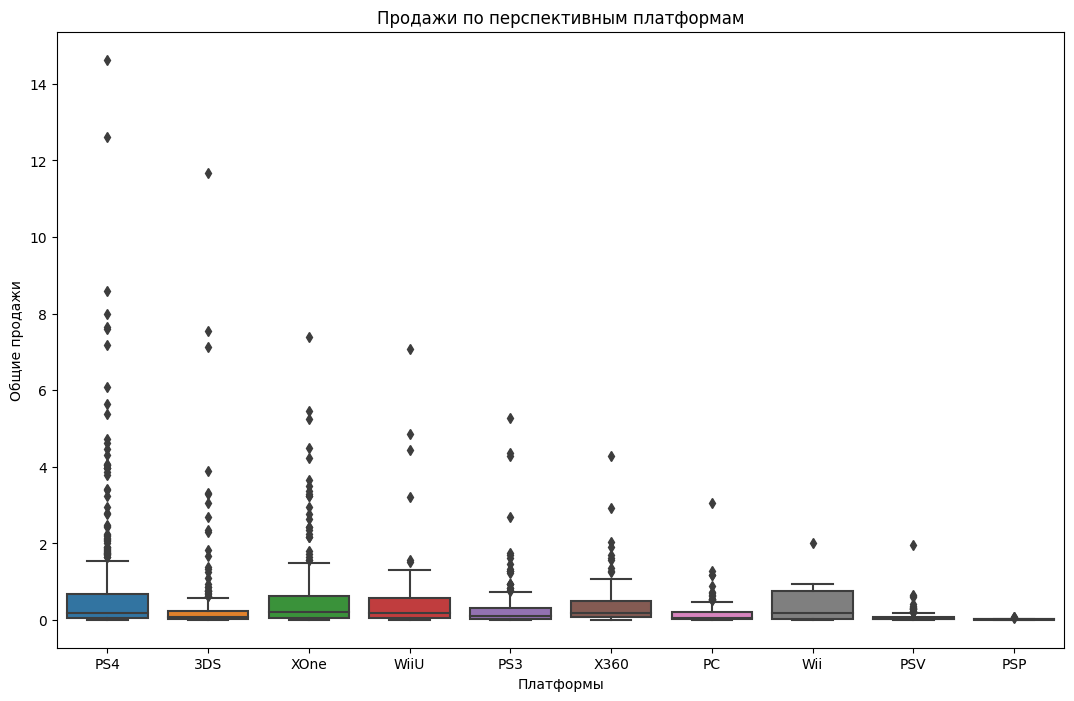

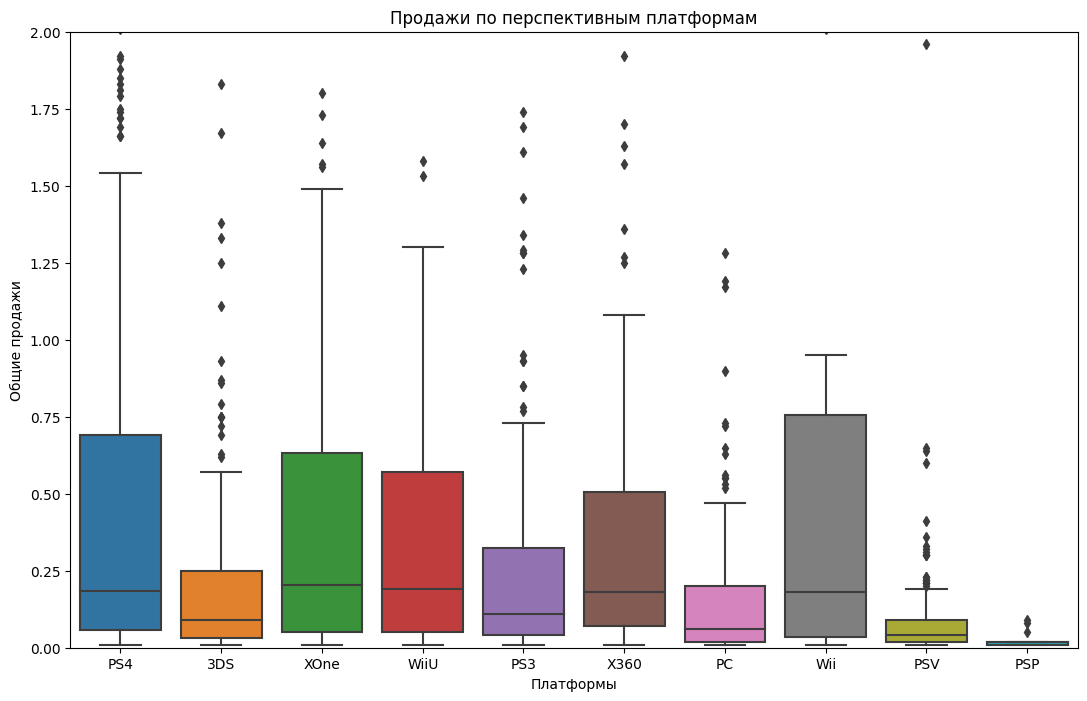

In [23]:
import seaborn as sns
data_temp, y = data, 'sum_sales_game'
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='platform')
    .set(title = 'Продажи по перспективным платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()
plt.figure(figsize=(13, 8))
(sns.boxplot(data = data_temp, y = y, x='platform')
    .set(title = 'Продажи по перспективным платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 2)))
plt.show()

Из полученных данных мы можем оценить медианное значение, верхний квантиль (75%) и среднее отклонение. Чем больше среднее отклонение, тем больше будет будет значений отдалённых от нашей медианы, выходящих за пределы квантиля. Из этого можно сделать вывод, что есть платформы, которые зарабатывают за счет большого кол-ва среднепопулярных игр (PC, Wii, PSV, PSP), а есть, которые делают свой успех за счёт "выбросов", то есть очень успешных игр, приносящих огромные прибыли платформам(PS4, 3DS, XOne, WiiU, PS3) X360 у нас находится между этими двумя категориями, так как у нее в среднем достаточное кол-во игр в среднем имеют успех, но при этом есть и выбросы, хоть и не высокие.

<b> Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. </b>

Зависимость от отзывов пользователей:

In [24]:
data_top = data.query("platform in ['XOne', 'PS4', '3DS', 'PC']")

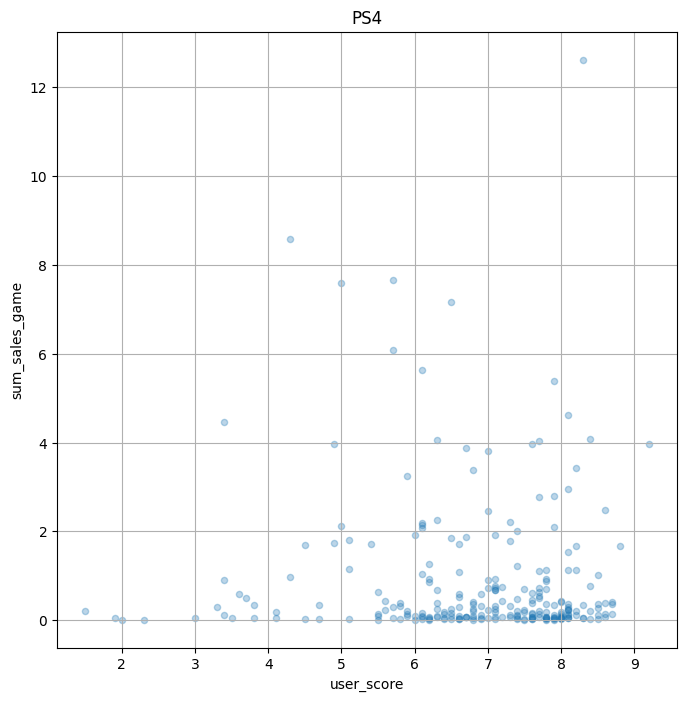

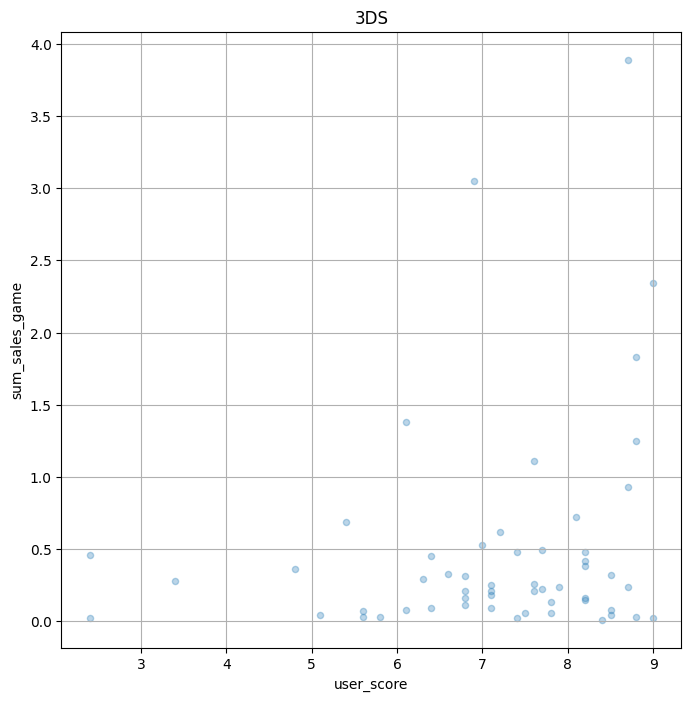

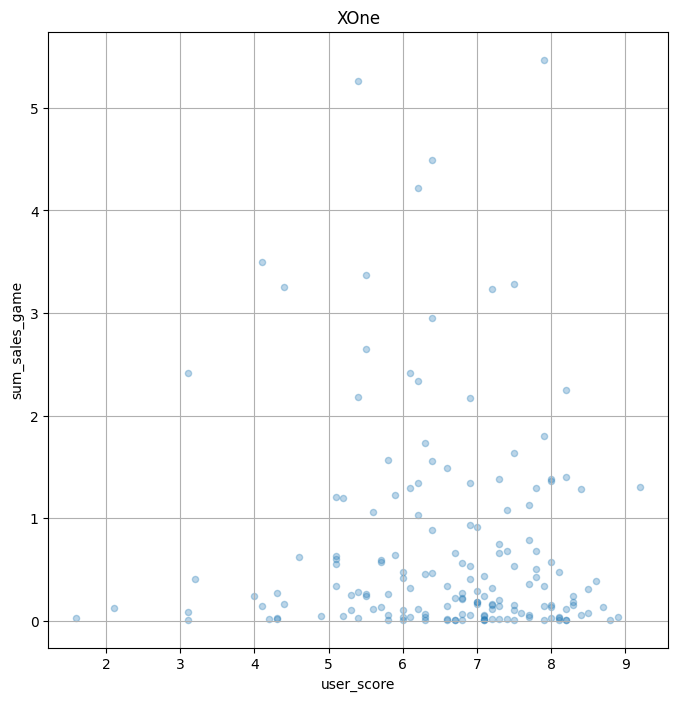

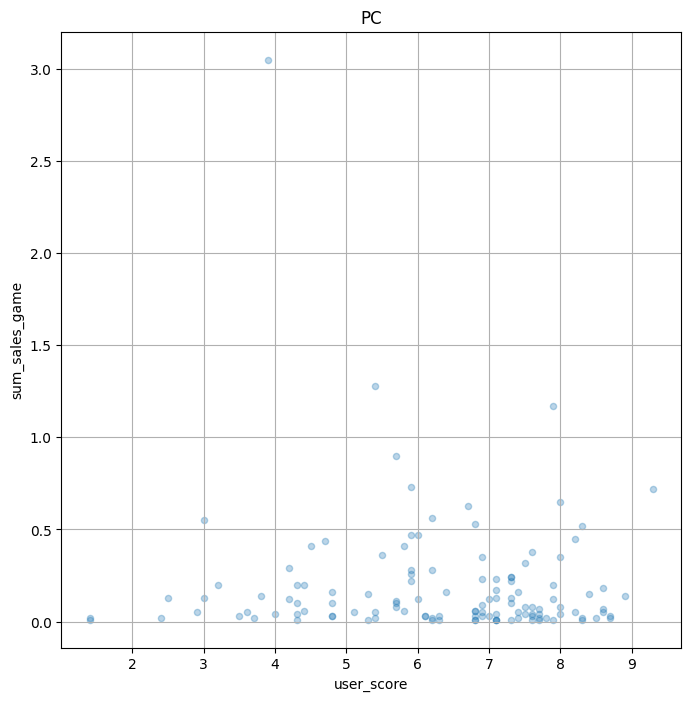

In [64]:
for i in data_top['platform'].unique():
    P = data_top.loc[data['platform'] == i]
    P.plot(x='user_score', y='sum_sales_game', kind='scatter', alpha=0.3, figsize=(8,8), grid=True)
    plt.title(i)
    plt.show()

In [26]:
for i in data_top['platform'].unique():
    P = data_top.loc[data_top['platform'] == i]
    print(P['user_score'].corr(P['sum_sales_game']))

-0.04013158947269733
0.2151932718527028
-0.07038392806475809
-0.07159665703472451


Вывод: Зависимости количества продаж от отзывов пользователей практически нет.

Зависимость от отзывов критиков:

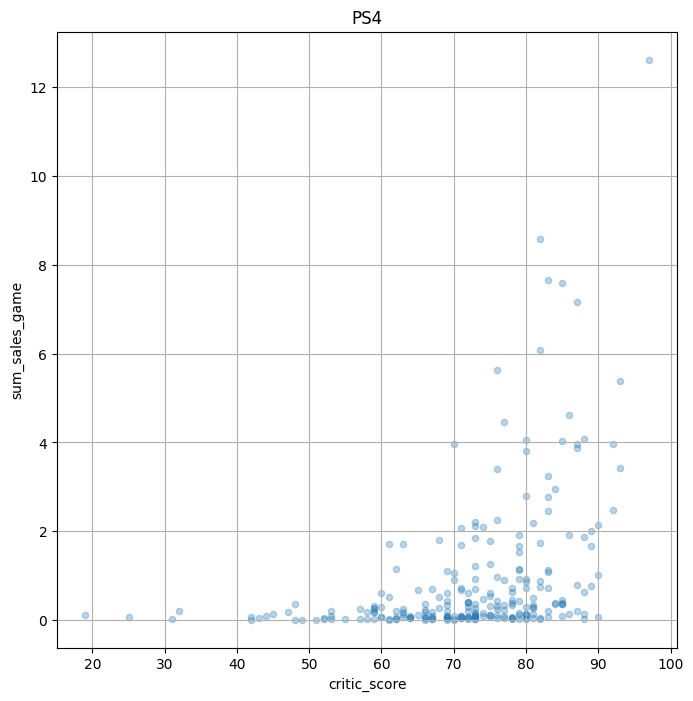

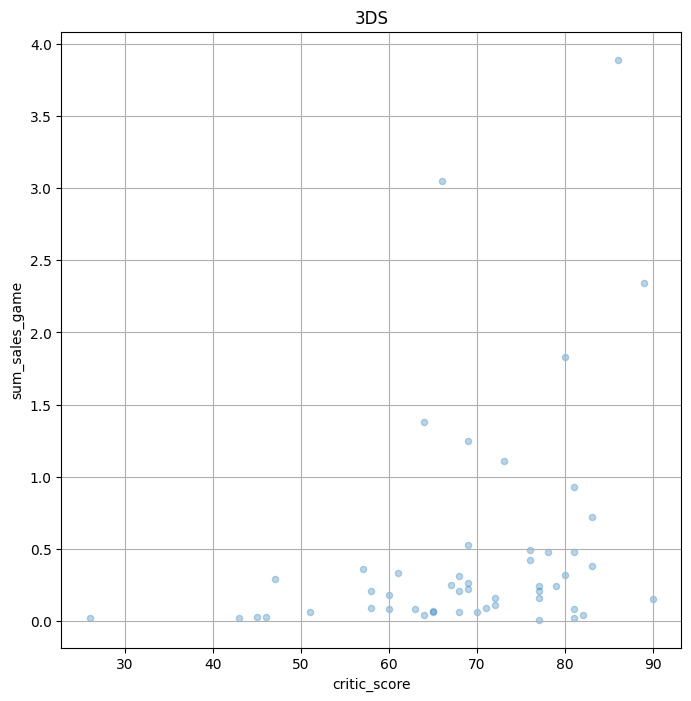

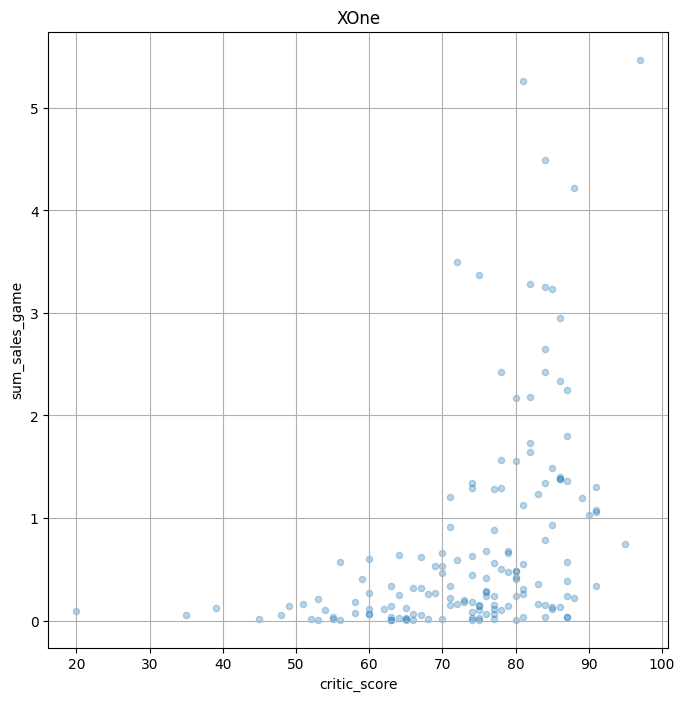

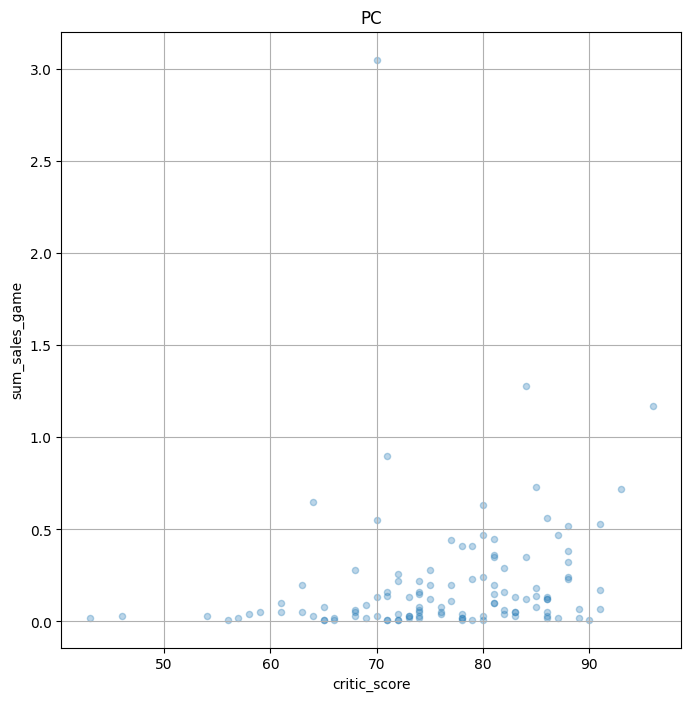

In [27]:
for i in data_top['platform'].unique():
    P = data_top.loc[data_top['platform'] == i]
    P.plot(x='critic_score', y='sum_sales_game', kind='scatter', alpha=0.3, figsize=(8,8), grid=True)
    plt.title(i)
    plt.show()

In [28]:
for i in data_top['platform'].unique():
    P = data_top.loc[data_top['platform'] == i]
    print(P['critic_score'].corr(P['sum_sales_game']))

0.4026614106810409
0.314117492869051
0.42867694370333187
0.17463413769350036


Вывод: Зависимости количества продаж от отзывов критиков и практически нет (слабоположительная).

<b> Соотнесем выводы с продажами игр на других платформах. </b>

Посмотрим зависимость других платформ от отзывов.

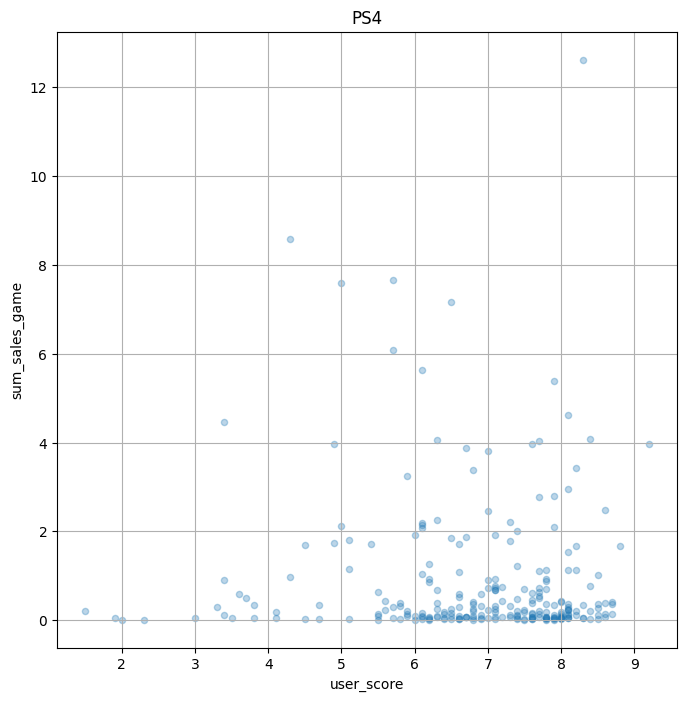

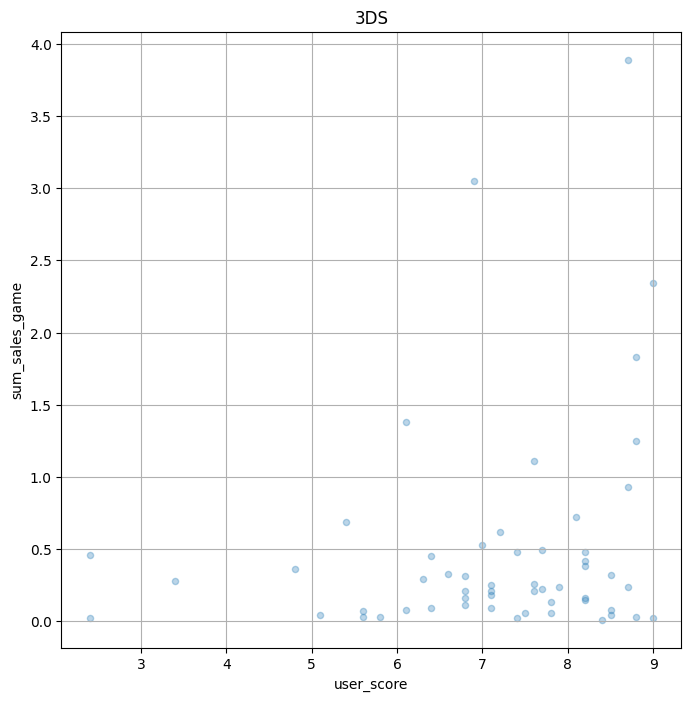

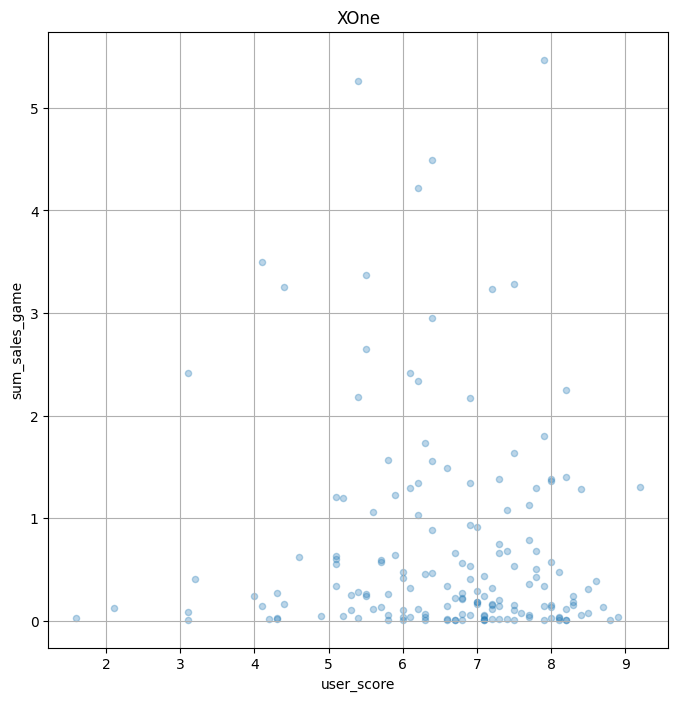

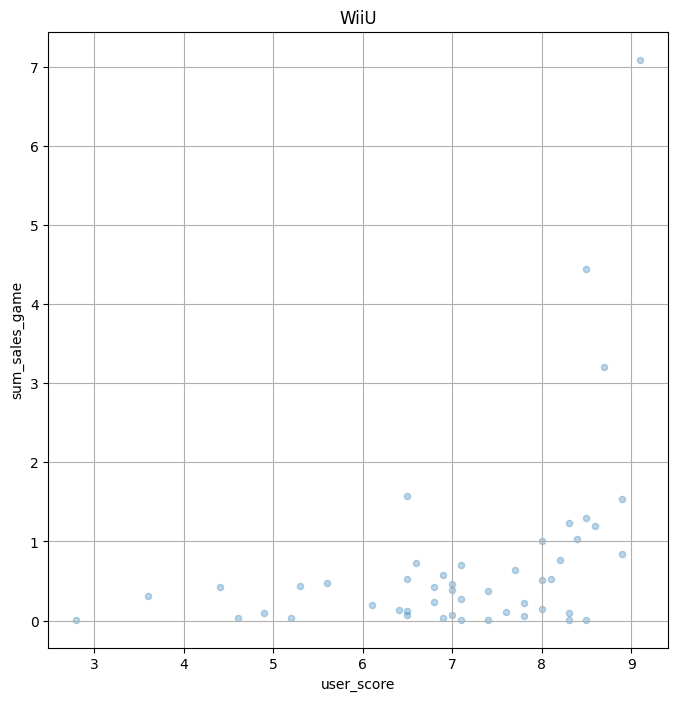

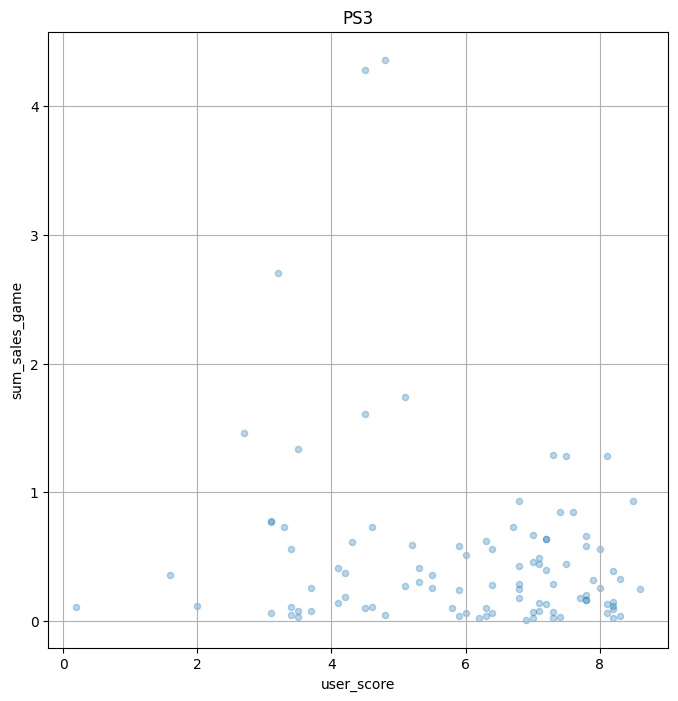

In [29]:
for i in data['platform'].unique()[:5]:
    P = data.loc[data['platform'] == i]
    P.plot(x='user_score', y='sum_sales_game', kind='scatter', alpha=0.3, figsize=(8,8), grid=True)
    plt.title(i)
    plt.show()

In [30]:
for i in data['platform'].unique()[:5]:
    P = data.loc[data['platform'] == i]
    print(P['user_score'].corr(P['sum_sales_game']))

-0.04013158947269733
0.2151932718527028
-0.07038392806475809
0.40792645792170773
-0.16676141347662118


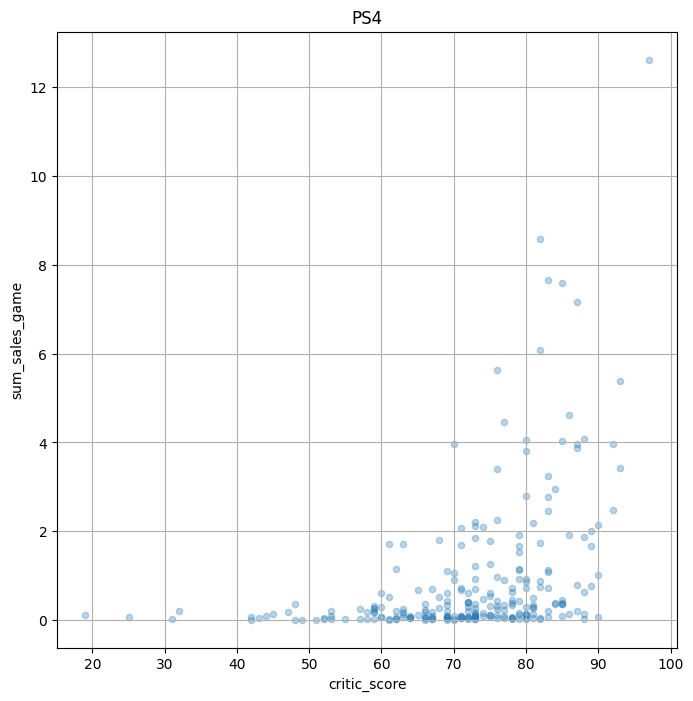

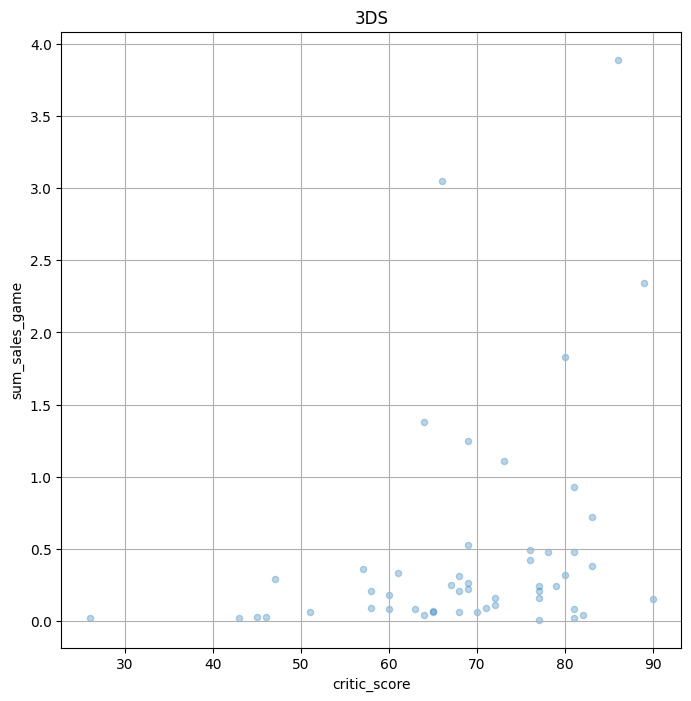

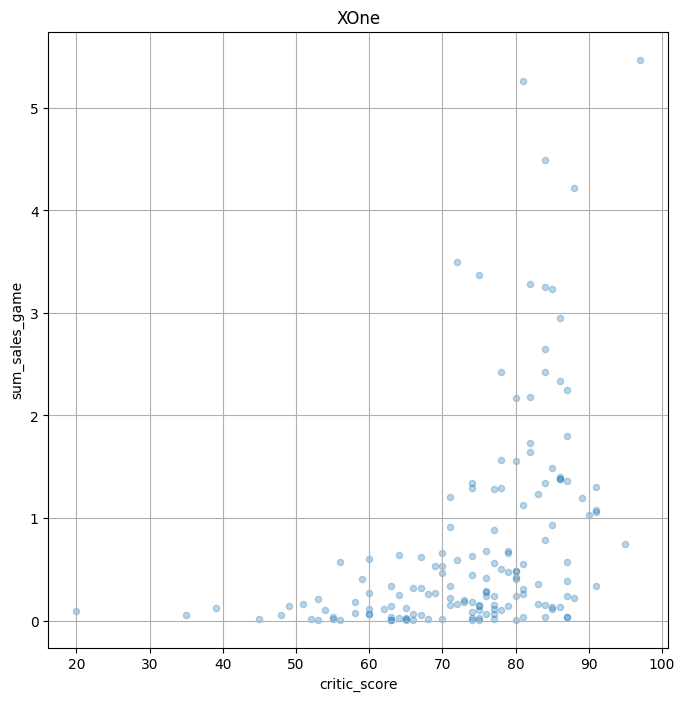

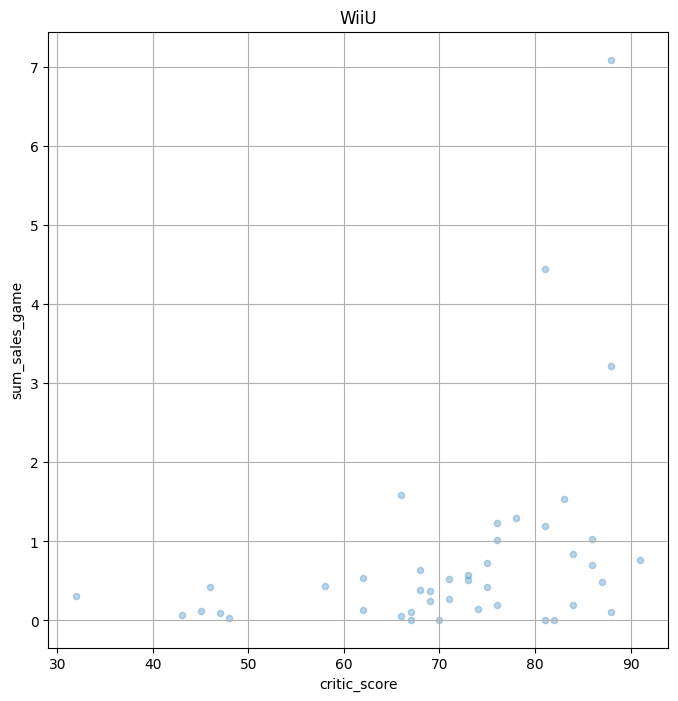

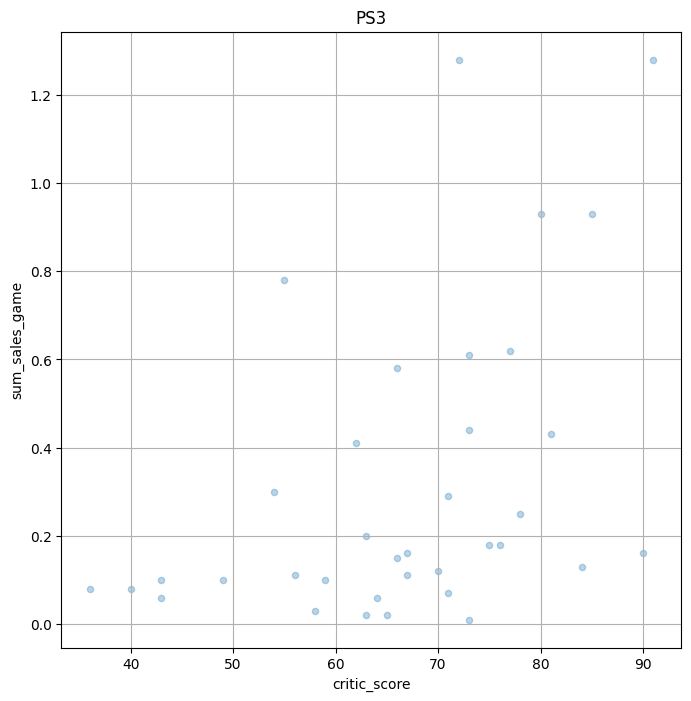

In [31]:
for i in data['platform'].unique()[:5]:
    P = data.loc[data['platform'] == i]
    P.plot(x='critic_score', y='sum_sales_game', kind='scatter', alpha=0.3, figsize=(8,8), grid=True)
    plt.title(i)
    plt.show()

In [32]:
for i in data['platform'].unique()[:5]:
    P = data.loc[data['platform'] == i]
    print(P['critic_score'].corr(P['sum_sales_game']))

0.4026614106810409
0.314117492869051
0.42867694370333187
0.370201412480884
0.44657460493190704


На других платформах также нет зависимости от оценки критиков и пользователей, как и в популярных платформах. 

Вывод: Как на популярных платформах, так и на других, зависимости от отзывов пользователей и критиков нет.

<b> Посмотрим на общее распределение игр по жанрам. </b>

Построим диаграмму размаха по общему распределнию игр по жанрам.

<Axes: title={'center': 'sum_sales_game'}, xlabel='genre'>

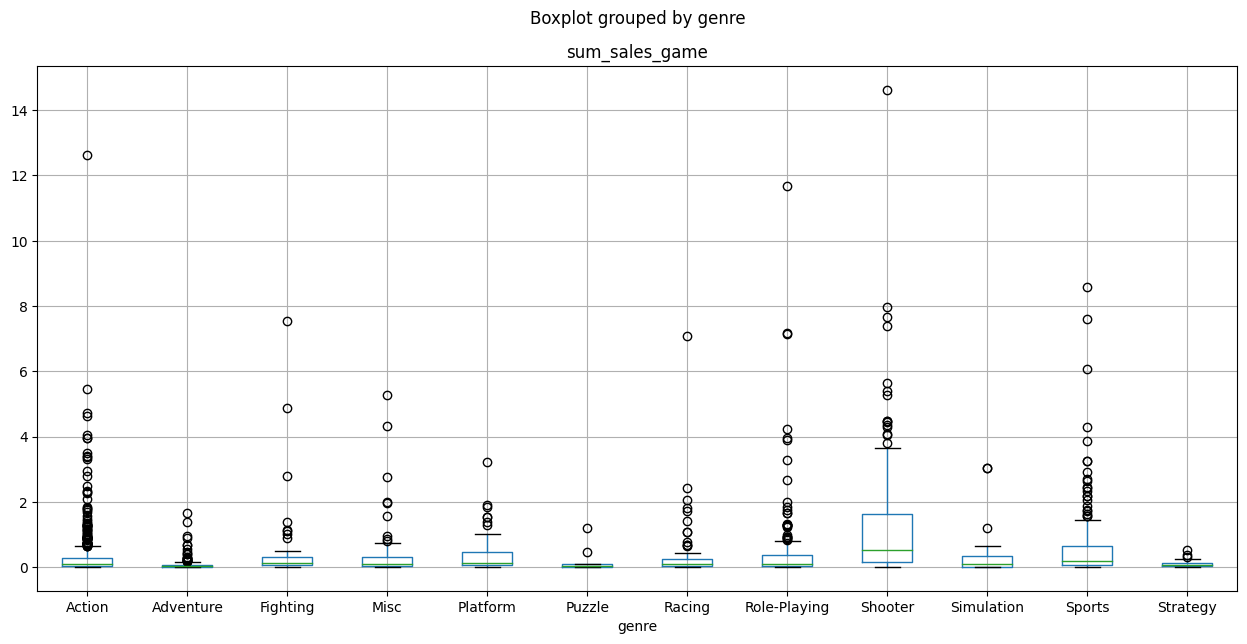

In [33]:
data.boxplot(column='sum_sales_game', by='genre', figsize=(15,7))

Чтобы детальней рассмотреть нижнюю часть боксплота, зададим паратемр в ylim:

(0.0, 1.0)

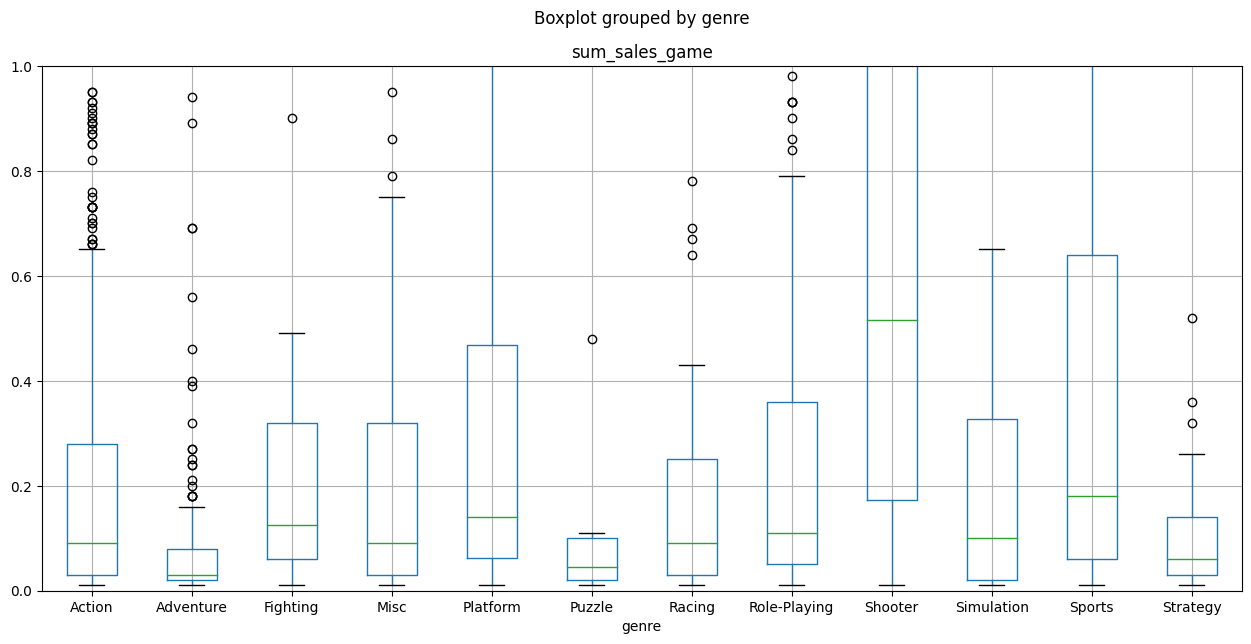

In [34]:
data.boxplot(column='sum_sales_game', by='genre', figsize=(15,7))
plt.ylim(0,1)

Вывод: 

По получившимся графикам и данным мы можем сделать вывод, что в жанрах так же, как и в платформах, некоторые имеют финансовый успех за счёт стабильно выпускаемых и продаваемых продуктов, у них мы наблюдаем более высокое медианное значение и длинный верхний квантиль(75%), некоторые же имея слабое медианное значение и низкий квантиль, имеют достаточно много выбросов (при выпуске большого числа игр достигают хорошего успеха далеко не все), что делает им выручку

К самым стабильным мы можем отнести: Shooter, Sports, Platform

К жанры, имеющим выручку за счёт хитов: Action, Role-Playing, Fighting, Racing, Adventure. Хотя сюда так же можно добавить и некоторые стабильные жанры (Shooter, Sports)

Рекомендации: работать больше со стабильными жанрами, которые при этом еще имеют и хиты, такие как Shooter, Sports, но так же рекомендовала бы обратить внимание на перспективные жанры Platform, Action, имеющие преимущества в своих сильных сторонах продаж

# Портрет пользователя каждого региона:


<b> Самые популярные платформы (топ-5). </b>

In [35]:
platform_count_full = data.groupby('platform')['sum_sales_game'].sum()

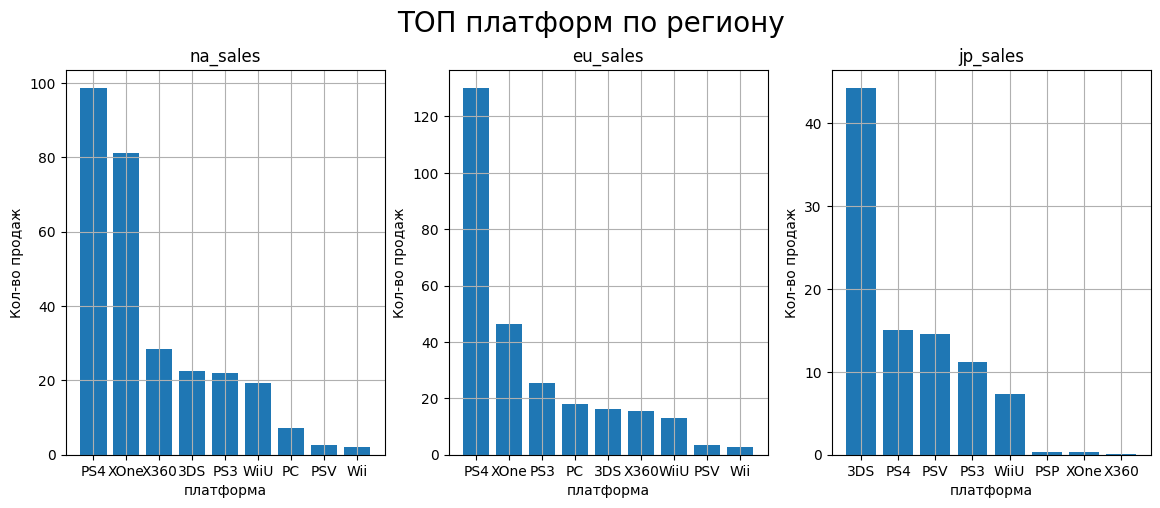

In [36]:
fig, axes = plt.subplots(1, 3)
n=0
for i in ('na_sales', 'eu_sales', 'jp_sales'):
    x = data.loc[data[i] > 0].pivot_table(index='platform', values=i, aggfunc='sum').sort_values(i, ascending=False)
    plt.subplot(1,3,1+n)
    plt.bar(x.index, x[i])
    plt.grid()
    plt.title(i)
    plt.xlabel('платформа')
    plt.ylabel('Кол-во продаж')
    n+=1
    percent_other = x / platform_count_full * 100
fig.suptitle('ТОП платформ по региону', y = 1, fontsize = 20)
fig.set_figheight(5)
fig.set_figwidth(14)
plt.show()

Построим наглядные круговые диаграммы - портрет покупателя.

In [37]:
data_games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
data_games.columns = map(str.lower, data_games.columns)
data_games = data_games.dropna(subset = ['year_of_release', 'name', 'genre'])
data_games['user_score'] = data_games['user_score'].replace('tbd', np.nan).astype('float')
data_games['rating'] = data_games['rating'].fillna('unknown')
data_games['total_sales'] = data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [70]:
# круги + категория другие
def graph_mini (data, year, region, name, axes):
 
# фильтруем датасет 
# x_year and year это одно и тоже, т.е. когда мы вызываем функцию мы передаем в функцию ряд параметров

    data = data.query('year_of_release >= @year')

# создаем сводную таблицу для круговой диаграммы
    
    sales = data.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()

# добавляем категорию

    sales = (
            sales._append({'platform': 'Other', region: data[region].sum() 
                       - sales[region].sum()}, ignore_index= True)
         )
    
# строим график

    sales.columns = ['platform', 'sales']
    sales.plot(kind='pie',
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, labels = sales.platform,
               
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel=''
                             )
    plt.tight_layout()

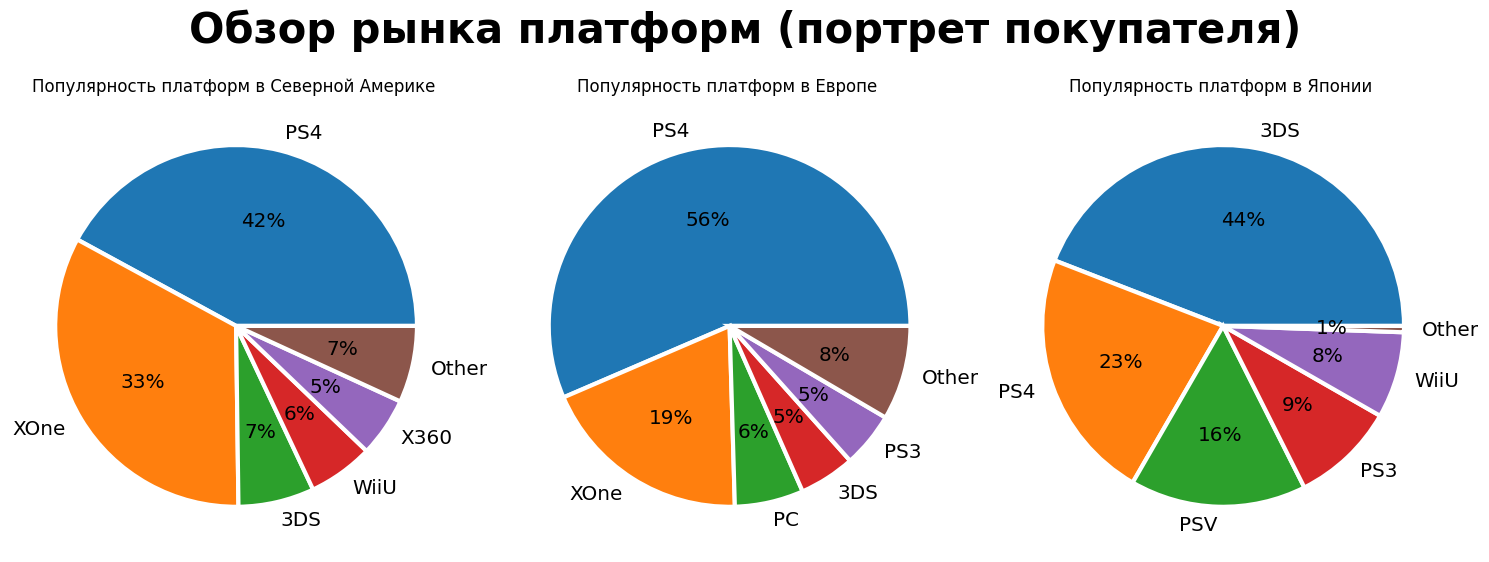

In [71]:
# круги в ряд
fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle('Обзор рынка платформ (портрет покупателя)', fontsize = 30, fontweight='bold')

x_year = 2015

graph_mini(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph_mini(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph_mini(data_games, x_year, 'jp_sales', 'Японии', axes[2])

Выяснили, что

в Северной Америке ТОП 5 платформ: PS4, XOne, X360, PS3, WiiU

в Европе ТОП 5 платформ: PS4, XOne, PS3, PC, X360

в Японии ТОП 5 платформ: 3DS, PS4, PSV, PS3, PSV

<b> Самые популярные жанры (топ-5). </b>

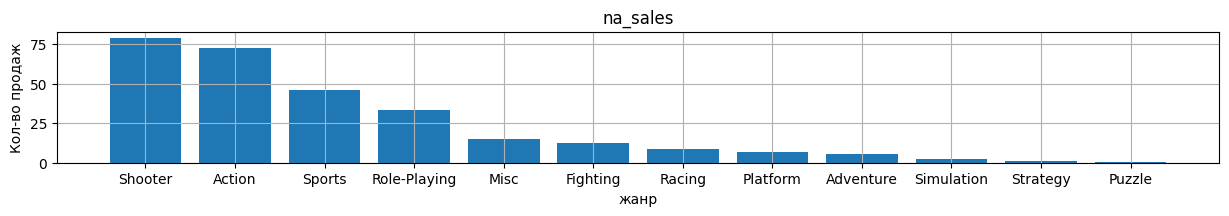

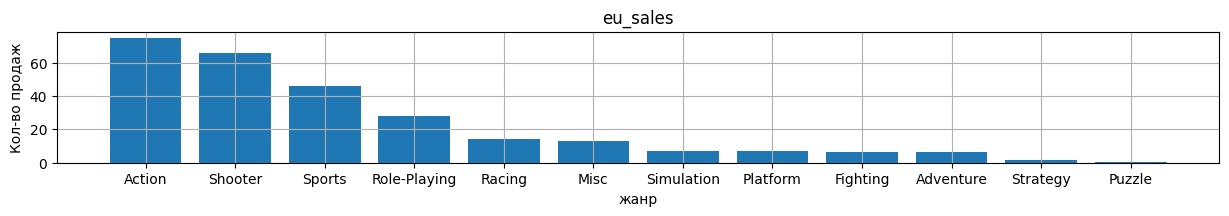

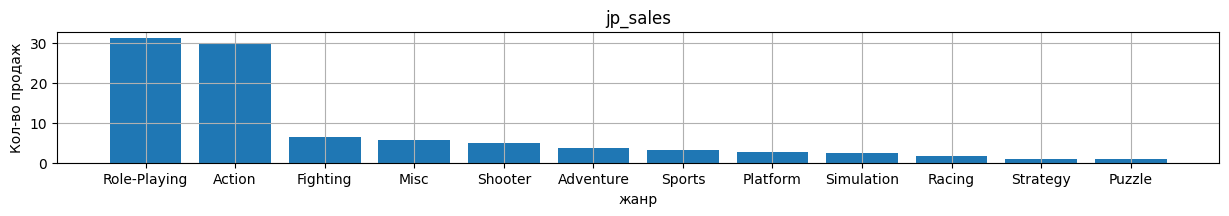

In [72]:
# определим самые популярные жанры в каждом регионе
for i in ('na_sales', 'eu_sales', 'jp_sales'):
    x = data.loc[data[i] > 0].pivot_table(index='genre', values=i, aggfunc='sum').sort_values(i, ascending=False)
    plt.figure(figsize=(15, 1.7))
    plt.bar(x.index, x[i])
    plt.title(i)
    plt.xlabel('жанр')
    plt.ylabel('Кол-во продаж')
    plt.grid()
    plt.show()

Выяснили, что

в Северной Америке ТОП 5 жанров: Shooter, Action, Sports, Role-Playing, Misc

в Европе ТОП 5 жанров: Action, Shooter, Sports, Role-Playing, Racing

в Японии ТОП 5 жанров: Role-Playing, Action, Fighting, Misc, Shooter


Рзаница может быть из-за разной национальной культуры в разных регионах. Так же видно, что в Япаонии на 50млн продаж меньше, это впринципе может быть из-за того, что в Японии на этих платформах играет меньше людей, либо данные о Японии не полные.

Так же причиной разницы могут быть разные рекламные акции, распределния населения по категориям "дети, подростки, молодые, взрослые, пожилые".

<b> Выясним, влияет ли рейтинг ESRB на продажи в отдельном регионе: <b/>

Построим график по рейтингам и регионам:

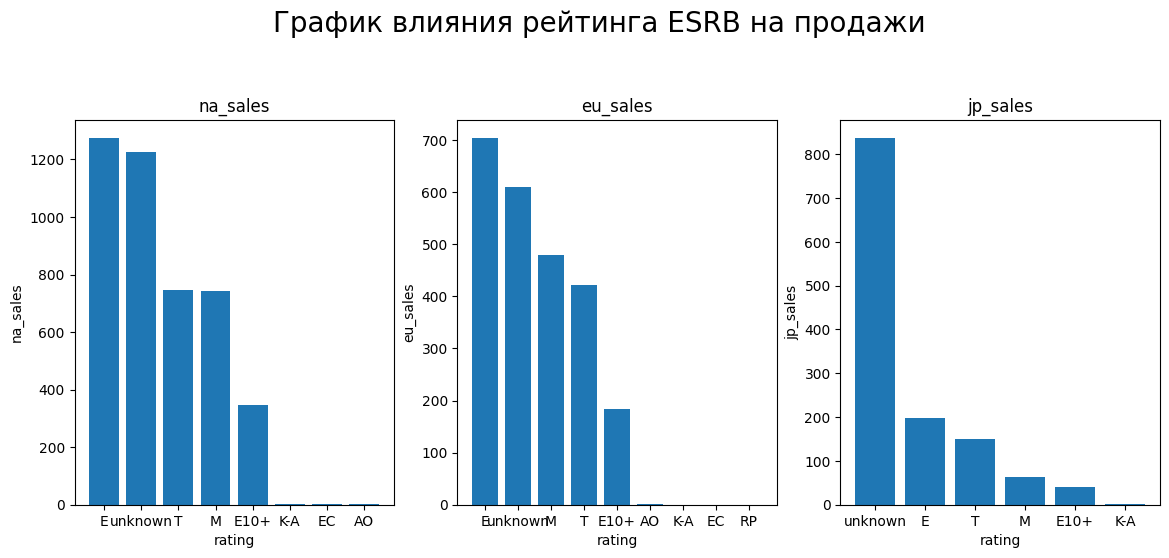

In [73]:
f, axes = plt.subplots(1,3)
n=0
for i in ('na_sales', 'eu_sales', 'jp_sales'):
    x = data_all.loc[data_all[i] > 0].pivot_table(index='rating', values=i, aggfunc='sum').sort_values(i, ascending=False)
    plt.subplot(1,3,1+n)
    #plt.figure(figsize=(12, 5))
    plt.bar(x.index, x[i])
    plt.title(i)
    plt.xlabel('rating')
    plt.ylabel(i)
    n += 1
f.suptitle('График влияния рейтинга ESRB на продажи', y=1.1, fontsize=20)
f.set_figheight(5)
f.set_figwidth(14)
plt.show()

Рейтинг Е (общий) имеет очень высокие продажи относительно остальных рейтингов: первое место - Северная Америка и Европа, второе - Япония. В Северной Америке и Японии на третьем месте расположился рейтинг Т, в Европе на третьем месте - М. - и эти игры выпущены в Северной Америке.

Второе место в Северной Америке, Европе и первое место в Японии занимает unknown, это говорит о том, что эти игры выпущены НЕ в Северной Америке, и о рейтинге этих игр достоверные выводы сделать невозможно.

## Проверка гипотез:

<b> №1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Определим нулевую и альтернативную гипотезы:

H0: средние рейтинги по платформам одинаковые

H1: средние рейтинги по платформам разные

In [74]:
data_xbox = data[data['platform'] == 'XOne']
data_pc = data[data['platform'] == 'PS4']
xbox_1 = data_xbox['user_score']
pc_1 = data_pc['user_score']
alpha = .05
results = st.ttest_ind(
xbox_1,
pc_1,
nan_policy='omit'
)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
  print("Отвергаем нулевую гипотезу")
else:
  print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.09668975421672579
Не получилось отвергнуть нулевую гипотезу


<b> №2 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Определим нулевую и альетрнативные гипотезы:

H0: средние рейтинги по жанрам одинаковые

H1: средние рейтинги по жанрам разные

In [75]:
data_action = data[data['genre'] == 'Action']
data_sports = data[data['genre'] == 'Sports']
action_1 = data_action['user_score']
sports_1 = data_sports['user_score']
alpha = .05
results = st.ttest_ind(
action_1,
sports_1,
nan_policy='omit'
)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
  print("Отвергаем нулевую гипотезу")
else:
  print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  2.8711147985107304e-19
Отвергаем нулевую гипотезу


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

Нулевая гипотеза всегда о равенстве чего-то, а альтернативная - всегда о неравенстве. - Отталкиваясь от этих знаний и H0 и H1. Критерий pvalue я выбрала 0.05, потому что чем меньше Р-значение, тем меньше вероятность допустить ошибку первого рода.

## Общий вывод:

 Построив графики по "сроку жизни" каждой платформы определили, что в среднем платформа живет 11 лет. Для дальнейшей работы отобрала актуальный период: с 2014 по 2016. За этот период самые большие продажы у PS4, еще хороший показатель продаж у XOne и  3DS. Считаю эти 3 платформы перспективными на 2017 год. Построив ящик с усами, определено, что некоторые плафтормы зарабатывают за счёт большого количества среднепопулярных игр (PC, Wii, PSV, PSP), а некоторые - за счёт "выстреливших" игр (PS4, 3DS, XOne, WiiU, PS3). В ходе исследования было определено, что зависимости продаж от оценки пользователей и критиков практически нет, на это упор в маркетинге можно не делать. Построив диаграмму размаза, тоже потверждается, что некоторые платформы работают на качество, а не на количество, а некоторые - выпускают много игр, многие из этих игр не успешные, но что-то выстреливает - это нестабильная стратегия. Поэтому рекомендация: работать больше со стабильными жанрами, которые при этом имеют еще и хиты (Shooter, Sports). Так же стоит обратить внимание на жанры Platform и Action - тоже "сильные" жанры, с высокими продажами.
Так же, при ориентации на разные регионы, можно отталкиваются от региональных топов платформ и жанров: 
в Северной Америке ТОП 5 платформ: PS4, XOne, X360, PS3, WiiU

в Европе ТОП 5 платформ: PS4, XOne, PS3, PC, X360

в Японии ТОП 5 платформ: 3DS, PS4, PSV, PS3, PSV.

в Северной Америке ТОП 5 жанров: Shooter, Action, Sports, Role-Playing, Misc

в Европе ТОП 5 жанров: Action, Shooter, Sports, Role-Playing, Racing

в Японии ТОП 5 жанров: Role-Playing, Action, Fighting, Misc, Shooter.

Рекомендация, исследовать, от чего зависит жанр в каждом регионе - чтобы основываясь на этой информации делать лУчшую рекламную акцию, ориентированную на специфику региона.

При ислледовании рейтинга было определено, что общий рейтинг, Т и M -рейтинги - одни из самых популярных, но так как для игр, выпущенных НЕ в Северной Америке, информации о рейтингах нет, точную рекомендацию дать не представляется возможным.

Выдвинутая гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, была отвергнута, значит, они не одиноковые.
Вторую гипотезу о том, что Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы - средние рейтинги по жанрам разные. 

На отзывы обращать внимание не стоит

Плафтормы - PS4, XOne, 

Жанр - к самым стабильным мы можем отнести: Shooter, Sports, Platform, игры с этими жанрами можно смело рекламировать.

рейтинг - E, T, правда, настораживает unknown, 

регион - самые высокие продажи в Северной Америке, если выбирать один регион для рекламы, рекомендую этот регион. 